In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
from pygam import LinearGAM, f, s, te 
from tueplots import bundles


citing pyGAM: Servén D., Brummitt C. (2018). pyGAM: Generalized Additive Models in Python. Zenodo. DOI: 10.5281/zenodo.1208723

In [3]:
# data load 
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)

print(mstl_data['city'].unique())

['Landeshauptstadt Stuttgart' 'city' 'Stadt Freiburg' 'Stadt Heidelberg'
 'Stadt Ludwigsburg' 'Stadt Mannheim' 'Stadt Reutlingen' 'Stadt Tübingen']


In [5]:
# extrahiere benötigte Spalten für GAMS
residual_data = mstl_data[['timestamp',
 'city',
 'counter_site',
'seasonal_8766',
'residual']].copy()
# filtert Zeilen raus, in denen anstatt Werten die Columnnames stehen
residual_data = residual_data[residual_data['timestamp']!='timestamp']
residual_data['res_8766'] = residual_data["seasonal_8766"].astype(float) + residual_data["residual"].astype(float)
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()
len(list(set(residual_data['id'].to_list())))
# merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']], right_on=['city', weather_data['date']], how='left')
# Referenzzeitpunkt (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist()))
print(ref)

# 1) Spalte vektorisiert in Datetime konvertieren (einmalig)
t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce')

# 2) Differenz in Stunden berechnen (vektorisiert)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0

def logdiff_to_percent(delta):
    return (np.exp(delta) - 1.0) * 100

2012-12-31 23:00:00+00:00


In [6]:
def defineX_y(city_data, forecast=False, full=False):
    y = city_data['res_8766'].astype(float).values

    if forecast:
        X = city_data[['timestamp_number', 'id',
                       'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float).copy()
        X.columns = ['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']

        # Keep only rows where forecast values exist and y exists
        mask = ~X[['temperature_2m', 'rain', 'snowfall']].isna().any(axis=1) & ~np.isnan(y)
        X = X[mask]
        y = y[mask]

    else:  # Use actual data
        X = city_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).copy()

        if full:
            # Keep all rows where actual values exist
            mask = ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]
        else:
            # Keep only rows where forecast exists (to align lengths)
            X_forecast = city_data[['forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float)
            mask = ~X_forecast.isna().any(axis=1) & ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]

    return X.values, y

def trainGAM(X,y):
    gam = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
    f(1, lam=50) +                       # id
    s(2, n_splines=6) +                  # temp
    s(3, n_splines=5, lam=2) +                               # rain
    s(4, n_splines=5, lam=2) +                               # snow
    te(2, 3, n_splines=4, lam=2)              # temp × rain
    ).fit(X, y)
    return gam

In [7]:
city_models = {"actual": {}, "predicted": {}}

for city in merged_data["city"].unique():
    city_data = merged_data[merged_data["city"] == city]
    X_act, y_act = defineX_y(city_data, forecast=False, full=False)
    gam_act = trainGAM(X_act, y_act)
    city_models["actual"][city] = {
        "gam": gam_act,
        "X": X_act,
        "y": y_act
    }

    X_pred, y_pred = defineX_y(city_data, forecast=True, full=False)
    gam_pred = trainGAM(X_pred, y_pred)
    city_models["predicted"][city] = {
        "gam": gam_pred,
        "X": X_pred,
        "y": y_pred
    }


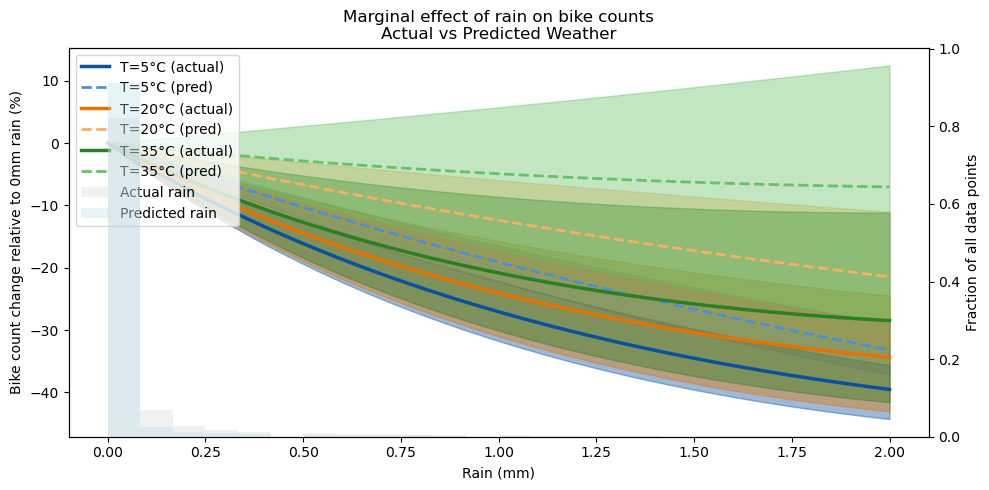

In [8]:
from matplotlib.colors import to_rgba

# -------------------------------------------------
# Helper
# -------------------------------------------------
def logdiff_to_percent(delta):
    """Convert log-scale differences to percent change"""
    return (np.exp(delta) - 1) * 100

# -------------------------------------------------
# Function to compute curves per dataset (actual/predicted)
# -------------------------------------------------
def compute_rain_curves(city_models, temps_fixed=[5, 20, 35], n_samples=500):
    """
    Compute city-level GAM curves for rain effects relative to rain=0 mm
    """
    rain_clip = np.percentile(np.vstack([v["X"] for v in city_models.values()])[:, 3], 99)
    rain_grid = np.linspace(0, rain_clip, 50)
    snow_fixed = 0.0

    city_curves_by_temp = {T: [] for T in temps_fixed}

    for city, data in city_models.items():
        X_city = data["X"]
        gam    = data["gam"]

        coef = gam.coef_
        cov  = gam.statistics_["cov"]
        coef_samples = np.random.multivariate_normal(coef, cov, size=n_samples)

        # base row: mean covariates except temperature/rain
        X_base = X_city.mean(axis=0)
        X_base[4] = snow_fixed  # fix snow

        for T in temps_fixed:
            # baseline row for rain=0
            X_base_temp = X_base.copy()
            X_base_temp[2] = T       # temperature fixed
            X_base_temp[3] = 0.0     # baseline rain
            X_base_mat  = gam._modelmat(np.tile(X_base_temp, (len(rain_grid), 1)))

            # reference rows for varying rain
            X_ref = np.tile(X_base, (len(rain_grid), 1))
            X_ref[:, 2] = T
            X_ref[:, 3] = rain_grid
            X_ref[:, 4] = snow_fixed
            X_ref_mat = gam._modelmat(X_ref)

            # percent difference relative to rain=0
            delta = (X_ref_mat - X_base_mat) @ coef_samples.T
            delta_pct = logdiff_to_percent(delta)

            # store mean curve for this city
            city_curves_by_temp[T].append(delta_pct.mean(axis=1))

    # aggregate across cities
    summary = {}
    for T in temps_fixed:
        curves = np.asarray(city_curves_by_temp[T])
        summary[T] = {
            "mean": curves.mean(axis=0),
            "low":  np.percentile(curves, 10, axis=0),
            "high": np.percentile(curves, 90, axis=0),
            "all": curves,
        }

    # rain grid
    return rain_grid, summary, rain_clip

# -------------------------------------------------
# Plot function
# -------------------------------------------------
def plot_rain_effect(city_models_actual, city_models_predicted, temps_fixed=[5, 20, 35], n_samples=500, n_bins=25):
    # --- compute curves ---
    rain_grid, summary_actual, rain_clip = compute_rain_curves(city_models_actual, temps_fixed, n_samples)
    _, summary_pred, _ = compute_rain_curves(city_models_predicted, temps_fixed, n_samples)

    # --- rain histogram ---
    all_actual = np.vstack([v["X"] for v in city_models_actual.values()])[:, 3]
    all_pred   = np.vstack([v["X"] for v in city_models_predicted.values()])[:, 3]

    bins = np.linspace(0, rain_clip, n_bins)
    counts_actual, _ = np.histogram(all_actual, bins=bins)
    counts_pred, _   = np.histogram(all_pred, bins=bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- plot ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    actual_colors = ["#08519c", "#e67300", "#2a7f24"]  # blue, orange, green
    pred_colors   = ["#4a90d9", "#fdae61", "#66c266"]  # lighter variants

    # Curves with CI
    for T, c_actual, c_pred in zip(temps_fixed, actual_colors, pred_colors):
        # actual: CI + solid line
        ax1.fill_between(rain_grid,summary_actual[T]["low"],summary_actual[T]["high"],color=to_rgba(c_actual, 0.40))
        ax1.plot(rain_grid, summary_actual[T]["mean"], lw=2.5, color=c_actual, label=f"T={T}°C (actual)")
        # predicted
        ax1.fill_between(rain_grid,summary_pred[T]["low"],summary_pred[T]["high"],color=to_rgba(c_pred, 0.40),        )
        ax1.plot(rain_grid, summary_pred[T]["mean"], lw=2, ls="--", color=c_pred, label=f"T={T}°C (pred)")

    # histogram bars
    ax2.bar(bin_centers, counts_actual / counts_actual.sum(), width=bins[1]-bins[0],
            color="lightgray", alpha=0.3, align="center", label="Actual rain")
    ax2.bar(bin_centers, counts_pred / counts_pred.sum(), width=bins[1]-bins[0],
            color="lightblue", alpha=0.3, align="center", label="Predicted rain")

    ax1.set_xlabel("Rain (mm)")
    ax1.set_ylabel("Bike count change relative to 0mm rain (%)")
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max((counts_actual / counts_actual.sum()).max(), (counts_pred / counts_pred.sum()).max())*1.1)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

    plt.title("Marginal effect of rain on bike counts\nActual vs Predicted Weather")
    plt.tight_layout()
    plt.show()


plot_rain_effect(city_models_actual=city_models["actual"],
                 city_models_predicted=city_models["predicted"])


In [ ]:
from matplotlib.colors import to_rgba
from tueplots import bundles

def plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
    temp_min=-10,
    temp_max=35,
    rain_levels=(0, 1.0, 3.0),
    n_bins=30
):
    # --- Compute curves with CIs ---
    def compute_curves(source):
        all_X = np.vstack([v["X"] for v in city_models[source].values()])
        global_mean_temp = all_X[:, temp_col].mean()
        temps = np.linspace(temp_min, temp_max, 30)
        snow_fixed = 0.0
        curves = {r: [] for r in rain_levels}

        for city, data in city_models[source].items():
            gam = data["gam"]
            X_city = data["X"]
            X_base = X_city.mean(axis=0)
            X_base[temp_col] = global_mean_temp
            X_base[rain_col] = 0.0
            X_base[snow_col] = snow_fixed
            X_base_mat = gam._modelmat(np.tile(X_base, (len(temps), 1)))

            for r in rain_levels:
                X_ref = np.tile(X_base, (len(temps), 1))
                X_ref[:, temp_col] = temps
                X_ref[:, rain_col] = r
                X_ref_mat = gam._modelmat(X_ref)
                delta_eta = (X_ref_mat - X_base_mat) @ gam.coef_
                curves[r].append((np.exp(delta_eta) - 1) * 100)

        # Aggregate across cities
        out = {}
        for r in rain_levels:
            arr = np.vstack(curves[r])
            out[r] = {
                "mean": arr.mean(axis=0),
                "low":  np.percentile(arr, 10, axis=0),
                "high": np.percentile(arr, 90, axis=0),
            }
        return temps, out, global_mean_temp

    # Compute curves
    temps, curves_actual, mean_temp = compute_curves("actual")
    _, curves_pred, _ = compute_curves("predicted")

    # --- Temperature histogram ---
    all_actual = np.vstack([v["X"] for v in city_models["actual"].values()])[:, temp_col]
    all_pred   = np.vstack([v["X"] for v in city_models["predicted"].values()])[:, temp_col]

    bins = np.linspace(temp_min, temp_max, n_bins)
    counts_actual, _ = np.histogram(all_actual, bins=bins)
    counts_pred, _   = np.histogram(all_pred, bins=bins)

    frac_actual = counts_actual / counts_actual.sum()
    frac_pred   = counts_pred / counts_pred.sum()

    #plt.rcParams.update(bundles.icml2024(column="full", nrows=1, ncols=2))
    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    width = bins[1] - bins[0]
    ax2.patch.set_alpha(0)

    # h<istogram bars
    h_actual = ax2.bar(bins[:-1], frac_actual, width=width, color="#f4d0c0", alpha=0.5, align="edge", zorder=1)
    h_pred = ax2.bar(bins[:-1], frac_pred,   width=width, color="#c0d4f4", alpha=0.5, align="edge", zorder=1)


    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max())*1.1)

    actual_colors = ["#08519c", "#e67300", "#2a7f24"]  # blue, orange, green
    pred_colors   = ["#4a90d9", "#fdae61", "#66c266"]  # lighter variants

    # Curves with CI
    for r, c_actual, c_pred in zip(rain_levels, actual_colors, pred_colors):
        # Actual: CI + solid line
        ax1.fill_between(
            temps,
            curves_actual[r]["low"],
            curves_actual[r]["high"],
            color=to_rgba(c_actual, 0.40),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_actual[r]["mean"],
            lw=2.5,
            color=c_actual,
            label=f"Rain={r} mm (actual)",
            zorder=3
        )

        # Predicted: CI + line
        ax1.fill_between(
            temps,
            curves_pred[r]["low"],
            curves_pred[r]["high"],
            color=to_rgba(c_pred, 0.40),
            zorder=2.5
        )
        ax1.plot(
            temps,
            curves_pred[r]["mean"],
            lw=2.5,
            color=c_pred,
            label=f"Rain={r} mm (pred)",
            zorder=4
        )

    # Global mean temp line
    ax1.axvline(mean_temp, color="red", lw=2, ls="--", label=f"Global mean temp ≈ {mean_temp:.1f}°C", zorder=4)
    ax1.axhline(0, color="black", lw=1, zorder=4)

    # Labels & title
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Bike count change relative to mean temp (%)")
    ax1.set_title("Temperature effect: actual vs predicted weather")

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2 = [h_actual, h_pred]  # explicit histogram handles
    labels2 = ["Actual temp", "Predicted temp"]
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()


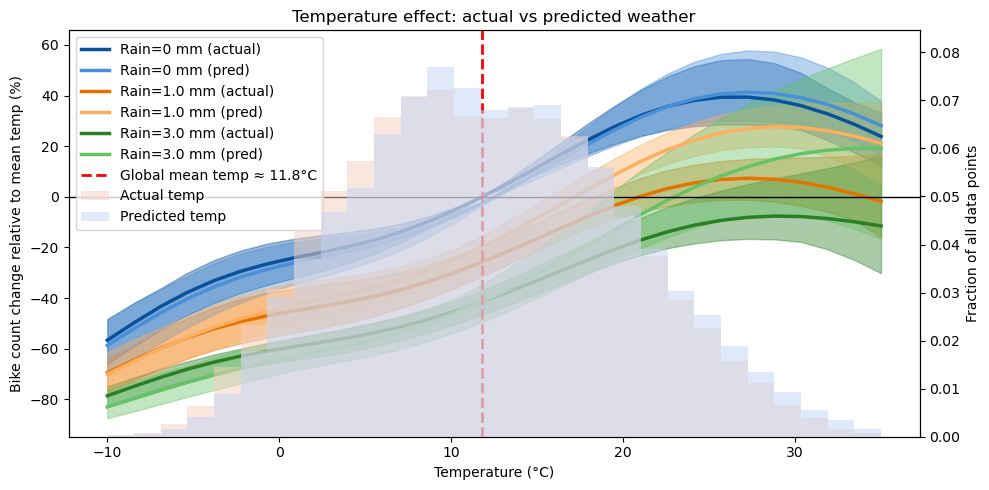

In [10]:
plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
)

##### Silja's Version

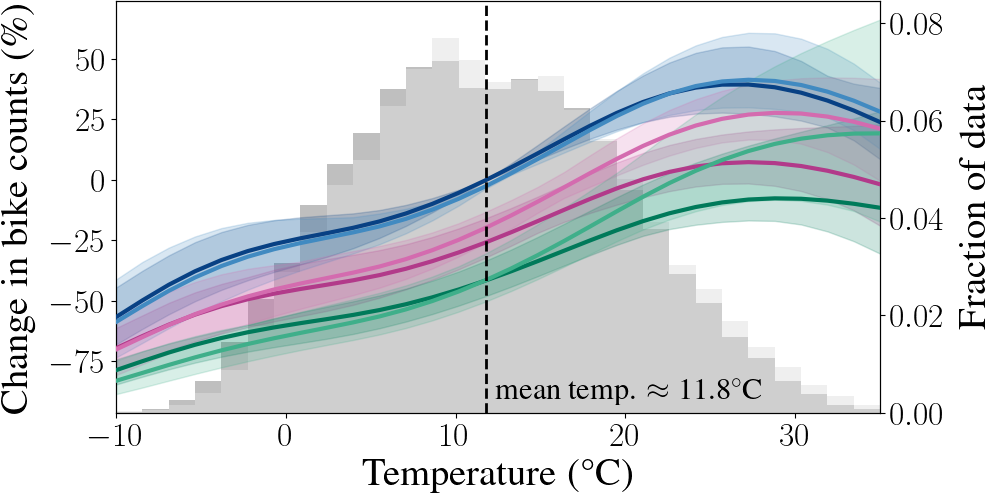

In [116]:
from matplotlib.colors import to_rgba


def plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
    temp_min=-10,
    temp_max=35,
    rain_levels=(0, 1.0, 3.0),
    n_bins=30
):
    # --- Compute curves with CIs ---
    def compute_curves(source):
        all_X = np.vstack([v["X"] for v in city_models[source].values()])
        global_mean_temp = all_X[:, temp_col].mean()
        temps = np.linspace(temp_min, temp_max, 30)
        snow_fixed = 0.0
        curves = {r: [] for r in rain_levels}

        for city, data in city_models[source].items():
            gam = data["gam"]
            X_city = data["X"]
            X_base = X_city.mean(axis=0)
            X_base[temp_col] = global_mean_temp
            X_base[rain_col] = 0.0
            X_base[snow_col] = snow_fixed
            X_base_mat = gam._modelmat(np.tile(X_base, (len(temps), 1)))

            for r in rain_levels:
                X_ref = np.tile(X_base, (len(temps), 1))
                X_ref[:, temp_col] = temps
                X_ref[:, rain_col] = r
                X_ref_mat = gam._modelmat(X_ref)
                delta_eta = (X_ref_mat - X_base_mat) @ gam.coef_
                curves[r].append((np.exp(delta_eta) - 1) * 100)

        # Aggregate across cities
        out = {}
        for r in rain_levels:
            arr = np.vstack(curves[r])
            out[r] = {
                "mean": arr.mean(axis=0),
                "low":  np.percentile(arr, 2.5, axis=0),
                "high": np.percentile(arr, 97.5, axis=0),
            }
        return temps, out, global_mean_temp

    # Compute curves
    temps, curves_actual, mean_temp = compute_curves("actual")
    _, curves_pred, _ = compute_curves("predicted")

    # --- Temperature histogram ---
    all_actual = np.vstack([v["X"] for v in city_models["actual"].values()])[:, temp_col]
    all_pred   = np.vstack([v["X"] for v in city_models["predicted"].values()])[:, temp_col]

    bins = np.linspace(temp_min, temp_max, n_bins)
    counts_actual, _ = np.histogram(all_actual, bins=bins)
    counts_pred, _   = np.histogram(all_pred, bins=bins)

    frac_actual = counts_actual / counts_actual.sum()
    frac_pred   = counts_pred / counts_pred.sum()

    # --- Plot ---
    plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Force histograms into background
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.patch.set_alpha(0)   # transparent so bars show through

    width = bins[1] - bins[0]
    ax2.patch.set_alpha(0)

    # Histogram bars
    h_actual = ax2.bar(
        bins[:-1], frac_actual,
        width=width, color="#808080", alpha=0.5,
        align="edge", zorder=0.5
    )
    h_pred = ax2.bar(
        bins[:-1], frac_pred,
        width=width, color="#E0E0E0", alpha=0.5,
        align="edge", zorder=0.5
    )

    ax2.set_ylabel("Fraction of data", fontsize=28, labelpad=10)
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)

    actual_colors = ["#084184", "#B23A8A", "#007A5A"]
    pred_colors   = ["#418ac1", "#D46BAF", "#3FAF8A"]

    # Curves with CI
    for r, c_actual, c_pred in zip(rain_levels, actual_colors, pred_colors):
        # Actual
        ax1.fill_between(
            temps,
            curves_actual[r]["low"],
            curves_actual[r]["high"],
            color=to_rgba(c_actual, 0.20),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_actual[r]["mean"],
            lw=3,
            color=c_actual,
            label=f"Rain={r} mm (obs.)",
            zorder=3
        )

        # Predicted
        ax1.fill_between(
            temps,
            curves_pred[r]["low"],
            curves_pred[r]["high"],
            color=to_rgba(c_pred, 0.20),
            zorder=2.5
        )
        ax1.plot(
            temps,
            curves_pred[r]["mean"],
            lw=3,
            color=c_pred,
            label=f"Rain={r} mm (pred.)",
            zorder=4
        )

    # Global mean temp line
    ax1.axvline(
        mean_temp,
        color="black",
        lw=2,
        ls="--",
        label=rf"Global mean temp $\approx$ {mean_temp:.1f}$^\circ$C",
        zorder=4
    )
    # Add text next to the line
    ax1.text(
        mean_temp + 0.5,  # slightly to the right of the line
        ax1.get_ylim()[1]*(-1.1),  # near top of y-axis
        rf"mean temp. $\approx$ {mean_temp:.1f}$^\circ$C",
        color="black",
        fontsize=22,
        ha="left",  # horizontal alignment
        va="top",   # vertical alignment
        rotation=0
    )
    # Labels, ticks, and axis limits
    ax1.set_xlabel("Temperature (°C)", fontsize=28)
    ax1.set_ylabel(r"Change in bike counts (\%)", fontsize=28, labelpad=10)
    ax1.set_yticks([-75, -50, -25, 0, 25, 50, 75])
    
    ax1.tick_params(axis='both', which='major', labelsize=24)
    ax2.tick_params(axis='y', which='major', labelsize=24)

    # Add margins at ends
    ax1.margins(x=0.02, y=0.05)

    # X-axis limits
    ax1.set_xlim(temp_min, temp_max)

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2 = [h_actual, h_pred]
    labels2 = ["Observed temperature", "Predicted temperature"]
    #ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", fontsize=14)

    fig.savefig("../figures/pred_vs_obs_wheather.pdf", format="pdf", bbox_inches="tight")
    plt.show()


plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
)

##### Other

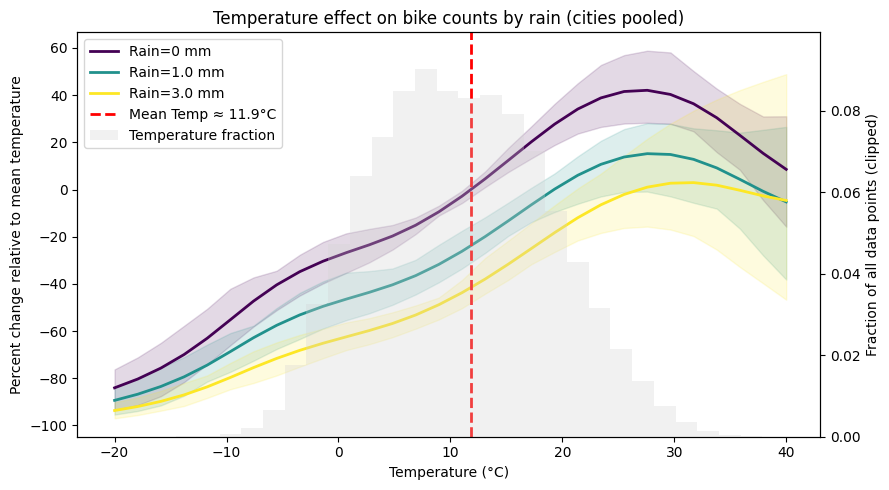

In [72]:
def plotMultipleCityGAMTempCurve(city_gams, city_Xs):
    temps = np.linspace(-20, 40, 30)
    rain_levels = [0, 1.0, 3.0]
    snow_fixed = 0.0

    city_coef_samples = {}
    n_draws = 1000
    for city, gam in city_gams.items():
        city_coef_samples[city] = np.random.multivariate_normal(
            gam.coef_,
            gam.statistics_['cov'],
            size=n_draws
        )


    city_curves_by_rain = {r: [] for r in rain_levels}

    for city, gam in city_gams.items():
        X_city = city_Xs[city]
        coef_samples = city_coef_samples[city]

        # baseline = mean row per city, average temperature
        X_base_row = X_city.mean(axis=0)
        X_base_row[2] = X_base_row[2]  # mean temp
        X_base_row[3] = 0.0
        X_base_row[4] = snow_fixed

        X_base = np.tile(X_base_row, (len(temps),1))
        X_base_mat = gam._modelmat(X_base)

        for r in rain_levels:
            X_ref_row = X_base_row.copy()
            X_ref_row[3] = r
            X_ref = np.tile(X_ref_row, (len(temps),1))
            X_ref[:,2] = temps  # vary temperature
            X_ref_mat = gam._modelmat(X_ref)

            delta_samples = (X_ref_mat - X_base_mat) @ coef_samples.T
            delta_percent = logdiff_to_percent(delta_samples)

            # store city-level mean curve
            city_curves_by_rain[r].append(delta_percent.mean(axis=1))

    mean_curves = {r: np.mean(city_curves_by_rain[r], axis=0) for r in rain_levels}
    lower_curves = {r: np.percentile(city_curves_by_rain[r], 10, axis=0) for r in rain_levels}
    upper_curves = {r: np.percentile(city_curves_by_rain[r], 90, axis=0) for r in rain_levels}

    fig, ax1 = plt.subplots(figsize=(9,5))
    ax2 = ax1.twinx()

    # temperature histogram across all cities
    all_temps = np.vstack(list(city_Xs.values()))[:, 2]
    temp_counts, temp_bins = np.histogram(all_temps, bins=30)
    temp_fraction = temp_counts / temp_counts.sum()   # <-- normalize to fraction of total

    clip_val = np.percentile(temp_fraction, 100)
    temp_fraction_clipped = np.clip(temp_fraction, 0, clip_val)

    ax2_bar = ax2.bar(
        temp_bins[:-1],
        temp_fraction,
        width=temp_bins[1] - temp_bins[0],
        color='lightgray',
        alpha=0.3,
        label="Temperature fraction"
    )

    ax2.set_ylabel("Fraction of all data points (clipped)")
    ax2.set_ylim(0, clip_val * 1.1)


    colors = plt.cm.viridis(np.linspace(0,1,len(rain_levels)))

    for r, color in zip(rain_levels, colors):
        # plot pooled mean with CI
        ax1.fill_between(temps, lower_curves[r], upper_curves[r], color=color, alpha=0.15)
        ax1.plot(temps, mean_curves[r], lw=2, color=color, label=f"Rain={r} mm")

        # plot each city as thin line
        #for city_curve in city_curves_by_rain[r]:
        #    ax1.plot(temps, city_curve, lw=1, color=color, alpha=0.5)

    mean_temp = all_temps.mean()
    ax1.axvline(mean_temp, color='red', linestyle='--', lw=2, label=f"Mean Temp ≈ {mean_temp:.1f}°C")

    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Percent change relative to mean temperature")
    ax1.set_title("Temperature effect on bike counts by rain (cities pooled)")
    handles1,labels1 = ax1.get_legend_handles_labels()
    handles2,labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles= handles1 + handles2, labels= labels1+labels2,loc='upper left')
    plt.tight_layout()
    plt.show()


In [83]:
def plotSingleGamRainCurve(X,y,gam):
    rain_clip = np.percentile(X[:, 3], 99)
    rain_grid = np.linspace(0, rain_clip, 50)
    temps = [-5, 5, 15, 25, 35]  # representative temperatures

    coef = gam.coef_
    cov  = gam.statistics_['cov']
    n_draws = 1000
    coef_samples = np.random.multivariate_normal(coef, cov, size=n_draws)
    fig, ax1 = plt.subplots(figsize=(9,5))

    # Plot GAM curves and CI
    for T in temps:
        X_ref_row = X.mean(axis=0)
        X_ref_row[2] = T      # temperature
        X_ref_row[4] = 0.0    # snow

        X_ref = np.tile(X_ref_row, (len(rain_grid), 1))
        X_ref[:, 3] = rain_grid

        X_base = X_ref.copy()
        X_base[:,3] = 0.0

        X_ref_mat = gam._modelmat(X_ref)
        X_base_mat = gam._modelmat(X_base)

        delta_samples = (X_ref_mat - X_base_mat) @ coef_samples.T
        delta_percent = logdiff_to_percent(delta_samples)

        mean_effect = delta_percent.mean(axis=1)
        ci_lower = np.percentile(delta_percent, 2.5, axis=1)
        ci_upper = np.percentile(delta_percent, 97.5, axis=1)

        ax1.fill_between(rain_grid, ci_lower, ci_upper, alpha=0.2)
        ax1.plot(rain_grid, mean_effect, lw=2, label=f"T={T}°C")

    ax1.set_xlabel("Rain (mm)")
    ax1.set_ylabel("Percent change relative to 0 mm")
    ax1.set_title("Effect of rain on bike counts at different temperatures (with 95% CI)")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    rain_values = np.clip(X[:,3], 0, rain_clip)
    counts, bins = np.histogram(rain_values, bins=30)
    scale = ax1.get_ylim()[1] / counts.max() * 0.3  # scale so histogram doesn't overwhelm curves
    ax2.bar(bins[:-1], counts * scale, width=bins[1]-bins[0], color='gray', alpha=0.3, edgecolor=None)
    ax2.set_ylabel("Rain frequency (scaled)")

    plt.show()


In [84]:
def plotSingleGAMTempCurve(X, y, gam):
    temps = np.linspace(-20, 35, 30)         # X-axis: temperature
    rain_levels = [0, 0.5, 1.0, 2.0, 3.0]   # Rain curves
    snow_fixed = 0.0

    coef = gam.coef_
    cov  = gam.statistics_['cov']
    n_draws = 1000
    coef_samples = np.random.multivariate_normal(coef, cov, size=n_draws)

    X_base_row = X.mean(axis=0)
    X_base_row[2] = X_base_row[2]  # average temperature
    X_base_row[3] = 0.0            # rain=0
    X_base_row[4] = snow_fixed
    X_base = np.tile(X_base_row, (len(temps), 1))
    X_base_mat = gam._modelmat(X_base)

    fig, ax1 = plt.subplots(figsize=(9,5))
    ax2 = ax1.twinx()  # secondary y-axis for histogram

    temp_counts, temp_bins = np.histogram(X[:,2], bins=30)
    clip_val = np.percentile(temp_counts, 95)
    temp_counts_clipped = np.clip(temp_counts, 0, clip_val)
    ax2.bar(temp_bins[:-1], temp_counts_clipped, width=temp_bins[1]-temp_bins[0],
            color='lightgray', alpha=0.3, label='Temperature frequency')
    ax2.set_ylabel("Temperature frequency (clipped)")
    ax2.set_ylim(0, clip_val*1.1)


    for r in rain_levels:
        X_ref_row = X.mean(axis=0)
        X_ref_row[3] = r
        X_ref_row[4] = snow_fixed

        X_ref = np.tile(X_ref_row, (len(temps),1))
        X_ref[:,2] = temps

        X_ref_mat = gam._modelmat(X_ref)

        delta_samples = (X_ref_mat - X_base_mat) @ coef_samples.T
        delta_percent = logdiff_to_percent(delta_samples)

        mean_effect = delta_percent.mean(axis=1)
        ci_lower = np.percentile(delta_percent, 2.5, axis=1)
        ci_upper = np.percentile(delta_percent, 97.5, axis=1)

        ax1.fill_between(temps, ci_lower, ci_upper, alpha=0.15)
        ax1.plot(temps, mean_effect, lw=2, label=f"Rain={r} mm")

    mean_temp = X[:,2].mean()
    ax1.axvline(mean_temp, color='red', linestyle='--', lw=2, label=f"Mean Temp ≈ {mean_temp:.1f}°C")
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Percent change relative to avg temp & 0 mm rain")
    ax1.set_title("Effect of temperature on bike counts by rain (with data distribution)")
    ax1.legend(loc='upper left')

    plt.show()
